# Social Listening & Monitoramento.

Este notebook simula um projeto de **Social Listening & Monitoramento** para uma marca fictícia (**MarcaX**) e dois concorrentes (**ConcorrenteA** e **ConcorrenteB**).

**O que você vai ver aqui:**
- Como estruturar uma base de menções (ex.: redes sociais e sites de reclamação).
- Limpeza e padronização de dados.
- Classificação de sentimento (abordagem simples e explicável).
- Métricas de monitoramento: **Share of Voice**, canais, temas e evolução no tempo.
- Sinais de alerta para **antecipar crises** (picos de volume e aumento de negativos).

> Observação: em um cenário real, a coleta viria de ferramentas/APIs (ex.: Brandwatch, Sprinklr, Talkwalker, Meltwater, X API, etc.). Aqui, usamos uma base sintética para demonstrar a metodologia.


## 1) Setup do projeto:

Vamos importar bibliotecas comuns de análise de dados e visualização.

**Dica (Google Colab):** este notebook roda direto no Colab.  
Se quiser, você pode enviar a pasta inteira do projeto para o Colab e executar tudo lá.


In [ ]:
# ============================
# 1) IMPORTAÇÕES
# ============================

# Importa o pandas para manipular tabelas (DataFrames).
import pandas as pd

# Importa numpy para operações numéricas e vetorização.
import numpy as np

# Importa módulos para trabalhar com caminhos de arquivo e diretórios.
import os

# Importa datetime para lidar com datas e horas.
from datetime import datetime

# Importa matplotlib para criar gráficos.
import matplotlib.pyplot as plt


## 2) Base de dados (menções):

A base contém:
- `data` (timestamp da menção).
- `marca` (MarcaX ou concorrentes).
- `canal` (Twitter/X, Instagram, ReclameAqui, etc.).
- `tema` (assunto principal).
- `texto` (o conteúdo da menção).
- `sentimento_rotulo` (rótulo “verdadeiro” da base sintética — usado para validação).


In [ ]:
# ============================
# 2) GERAR OU CARREGAR O CSV
# ============================

# Define o diretório do projeto (onde está este notebook).
# __file__ nem sempre existe no Colab, então usamos uma abordagem simples:
project_dir = os.getcwd()

# Define o caminho da pasta de dados.
data_dir = os.path.join(project_dir, "data")

# Cria a pasta "data" se ela não existir.
os.makedirs(data_dir, exist_ok=True)

# Define o caminho do arquivo CSV.
csv_path = os.path.join(data_dir, "mencoes.csv")

# Se o CSV não existir, gera uma base sintética.
if not os.path.exists(csv_path):
    # (1) Define listas para montar textos com diferentes sentimentos.
    marcas = ["MarcaX", "ConcorrenteA", "ConcorrenteB"]
    canais = ["Twitter/X", "Instagram", "TikTok", "ReclameAqui", "YouTube", "Facebook"]
    temas = ["atendimento", "entrega", "preço", "qualidade", "app", "pagamento", "suporte", "promoção"]
    termos_setor = ["frete", "cashback", "PIX", "cupom", "atraso", "garantia", "reembolso"]

    positivos = [
        "Amei a experiência com {brand}, atendimento rápido e super educado!",
        "{brand} mandou muito bem na entrega, chegou antes do prazo.",
        "Promoção incrível da {brand}, valeu demais o cupom!",
        "Qualidade excelente, {brand} ganhou meu respeito.",
        "O app da {brand} ficou muito melhor depois da atualização. Parabéns!",
        "Suporte da {brand} resolveu meu problema em minutos. Top!"
    ]

    negativos = [
        "Que decepção com {brand}: entrega atrasada e ninguém responde.",
        "Atendimento horrível da {brand}, fiquei horas esperando.",
        "Comprei e veio com defeito. {brand} não quer reembolsar!",
        "Preço alto e qualidade ruim. {brand} piorou muito.",
        "O app da {brand} trava toda hora, impossível usar.",
        "Prometeram cashback e não caiu. {brand} enrolando."
    ]

    neutros = [
        "Alguém sabe se a {brand} aceita PIX?",
        "Vi uma propaganda da {brand} hoje, parece interessante.",
        "Estou comparando {brand} com outras opções por causa do preço.",
        "Quais são os horários de atendimento da {brand}?",
        "Onde encontro cupom da {brand}?",
        "A {brand} tem garantia estendida?"
    ]

    # (2) Função auxiliar para criar uma linha.
    def criar_linha(i, inicio):
        # Distribui sentimentos de forma controlada.
        if i < 18:
            sentimento = "Positivo"
            template = np.random.choice(positivos)
        elif i < 34:
            sentimento = "Negativo"
            template = np.random.choice(negativos)
        else:
            sentimento = "Neutro"
            template = np.random.choice(neutros)

        marca = np.random.choice(marcas)
        canal = np.random.choice(canais)
        tema = np.random.choice(temas)
        termo = np.random.choice(termos_setor)

        texto = template.format(brand=marca) + f" ({tema}, {termo})"

        # Simula um "pico" de crise no fim do período (mais negativos para MarcaX).
        if i >= 40:
            marca = "MarcaX"
            canal = np.random.choice(["ReclameAqui", "Twitter/X"])
            sentimento = "Negativo" if np.random.rand() < 0.75 else "Neutro"
            template2 = np.random.choice(negativos if sentimento == "Negativo" else neutros)
            texto = template2.format(brand=marca) + f" ({tema}, {termo})"

        # Gera uma data aleatória dentro de ~20 dias.
        horas_aleatorias = int(np.random.randint(0, 24 * 20))
        data = inicio + pd.Timedelta(hours=horas_aleatorias)

        return {
            "id": 1000 + i,
            "data": data.strftime("%Y-%m-%d %H:%M:%S"),
            "marca": marca,
            "canal": canal,
            "tema": tema,
            "texto": texto,
            "sentimento_rotulo": sentimento
        }

    # (3) Cria as 50 linhas.
    inicio = pd.Timestamp("2026-01-10 09:00:00")
    linhas = [criar_linha(i, inicio) for i in range(50)]

    # (4) Monta o DataFrame e salva.
    df_gerado = pd.DataFrame(linhas).sort_values("data").reset_index(drop=True)
    df_gerado.to_csv(csv_path, index=False, encoding="utf-8")

# Carrega o CSV (seja o já existente, seja o que acabamos de gerar).
df = pd.read_csv(csv_path)

# Mostra as primeiras linhas.
df.head()


,id,data,marca,canal,tema,texto,sentimento_rotulo
0,1024,2026-01-10 11:00:00,MarcaX,TikTok,qualidade,"Atendimento horrível da MarcaX, fiquei horas e...",Negativo
1,1010,2026-01-10 19:00:00,ConcorrenteA,TikTok,entrega,"Promoção incrível da ConcorrenteA, valeu demai...",Positivo
2,1014,2026-01-11 09:00:00,MarcaX,Instagram,promoção,"MarcaX mandou muito bem na entrega, chegou ant...",Positivo
3,1008,2026-01-12 20:00:00,ConcorrenteA,Twitter/X,promoção,"Promoção incrível da ConcorrenteA, valeu demai...",Positivo
4,1020,2026-01-13 01:00:00,ConcorrenteB,Facebook,suporte,"O app da ConcorrenteB trava toda hora, impossí...",Negativo


## 3) Tratamento e padronização (data, texto e categorias):

Aqui é onde você garante qualidade mínima para:
- análises por tempo (dia/semana/mês).
- agrupamentos por marca/canal/tema.
- pipelines repetíveis (sempre do mesmo jeito).

Vamos:
1. Converter `data` para datetime.
2. Criar colunas de **dia** e **semana**.
3. Normalizar texto (minúsculas) em uma coluna auxiliar.


In [ ]:
# ============================
# 3) LIMPEZA E FEATURES BÁSICAS
# ============================

# Converte a coluna "data" (string) para datetime.
df["data"] = pd.to_datetime(df["data"])

# Cria uma coluna apenas com a data (dia), útil para agregações diárias.
df["dia"] = df["data"].dt.date

# Cria uma coluna com o início da semana (segunda-feira), útil para agregações semanais.
df["semana"] = df["data"].dt.to_period("W").apply(lambda p: p.start_time.date())

# Cria uma versão do texto em minúsculas para facilitar regras de classificação.
df["texto_lower"] = df["texto"].astype(str).str.lower()

# Checagem rápida.
df[["data", "dia", "semana", "marca", "canal", "tema", "texto"]].head()


,data,dia,semana,marca,canal,tema,texto
0,2026-01-10 11:00:00,2026-01-10,2026-01-05,MarcaX,TikTok,qualidade,"Atendimento horrível da MarcaX, fiquei horas e..."
1,2026-01-10 19:00:00,2026-01-10,2026-01-05,ConcorrenteA,TikTok,entrega,"Promoção incrível da ConcorrenteA, valeu demai..."
2,2026-01-11 09:00:00,2026-01-11,2026-01-05,MarcaX,Instagram,promoção,"MarcaX mandou muito bem na entrega, chegou ant..."
3,2026-01-12 20:00:00,2026-01-12,2026-01-12,ConcorrenteA,Twitter/X,promoção,"Promoção incrível da ConcorrenteA, valeu demai..."
4,2026-01-13 01:00:00,2026-01-13,2026-01-12,ConcorrenteB,Facebook,suporte,"O app da ConcorrenteB trava toda hora, impossí..."


## 4) Sentimento (modelo simples e explicável):

Em Social Listening, sentimento ajuda a:
- medir percepção (positivos vs negativos).
- sinalizar riscos (alta de negativos).
- priorizar temas (ex.: entrega vs atendimento).

Para portfólio, vamos usar uma abordagem **lexicon-based** (lista de palavras) .— simples, rápida e fácil de explicar em entrevista.

**Como funciona:**
- contamos palavras positivas e negativas no texto.
- calculamos um score = positivos - negativos.
- mapeamos para: Positivo / Negativo / Neutro.

> Em produção, você pode evoluir para modelos de NLP (BERT em PT-BR, etc.) e validação com amostras rotuladas.


In [ ]:
# ============================
# 4) CLASSIFICAÇÃO DE SENTIMENTO (LEXICON)
# ============================

# Lista simples de palavras positivas/negativas (PT-BR) — você pode expandir.
palavras_positivas = {
    "amei", "incrível", "excelente", "parabéns", "top", "rápido", "resolvido",
    "melhor", "ótimo", "boa", "bom", "perfeito", "recomendo", "gostei"
}

palavras_negativas = {
    "decepção", "horrível", "atrasada", "atraso", "defeito", "reembolsar", "ruim",
    "trava", "impossível", "enrolando", "piorou", "caro", "não responde", "demora"
}

# Função para tokenizar de forma simples (quebra por espaços e remove pontuação básica).
def tokenizar(texto: str) -> list:
    # Garante que o texto é string.
    texto = str(texto)

    # Remove alguns sinais comuns (abordagem simples).
    for ch in [".", ",", "!", "?", ":", ";", "(", ")", "—", "-", "\"", "'"]:
        texto = texto.replace(ch, " ")

    # Separa por espaços e remove tokens vazios.
    tokens = [t for t in texto.split() if t.strip() != ""]
    return tokens

# Função de sentimento baseada em contagem.
def sentimento_lexicon(texto_lower: str) -> tuple:
    # Tokeniza o texto.
    tokens = tokenizar(texto_lower)

    # Conta quantas palavras positivas e negativas aparecem.
    pos = sum(1 for t in tokens if t in palavras_positivas)
    neg = sum(1 for t in tokens if t in palavras_negativas)

    # Calcula score (simples e interpretável).
    score = pos - neg

    # Define o rótulo com base no score.
    if score > 0:
        rotulo = "Positivo"
    elif score < 0:
        rotulo = "Negativo"
    else:
        rotulo = "Neutro"

    return rotulo, score, pos, neg

# Aplica a função linha a linha e cria colunas novas.
df[["sentimento_pred", "score", "qtd_pos", "qtd_neg"]] = (
    df["texto_lower"]
      .apply(lambda t: pd.Series(sentimento_lexicon(t)))
)

# Visualiza amostras.
df[["marca", "canal", "tema", "texto", "sentimento_rotulo", "sentimento_pred", "score"]].head(10)

,marca,canal,tema,texto,sentimento_rotulo,sentimento_pred,score
0,MarcaX,TikTok,qualidade,"Atendimento horrível da MarcaX, fiquei horas e...",Negativo,Negativo,-1
1,ConcorrenteA,TikTok,entrega,"Promoção incrível da ConcorrenteA, valeu demai...",Positivo,Neutro,0
2,MarcaX,Instagram,promoção,"MarcaX mandou muito bem na entrega, chegou ant...",Positivo,Neutro,0
3,ConcorrenteA,Twitter/X,promoção,"Promoção incrível da ConcorrenteA, valeu demai...",Positivo,Positivo,1
4,ConcorrenteB,Facebook,suporte,"O app da ConcorrenteB trava toda hora, impossí...",Negativo,Negativo,-2
5,ConcorrenteB,TikTok,app,"Amei a experiência com ConcorrenteB, atendimen...",Positivo,Positivo,2
6,MarcaX,ReclameAqui,atendimento,"MarcaX mandou muito bem na entrega, chegou ant...",Positivo,Neutro,0
7,MarcaX,Twitter/X,preço,Quais são os horários de atendimento da MarcaX...,Neutro,Negativo,-1
8,ConcorrenteA,Instagram,entrega,Preço alto e qualidade ruim. ConcorrenteA pior...,Negativo,Negativo,-3
9,ConcorrenteA,Instagram,qualidade,Prometeram cashback e não caiu. ConcorrenteA e...,Negativo,Negativo,-1


## 5) Validação rápida (apenas para a base sintética):

Como nossa base tem `sentimento_rotulo`, dá para medir acerto.

Em um caso real, você faria:
- amostragem e rotulagem manual.
- cálculo de métricas (accuracy, precision/recall por classe).
- revisão contínua do modelo.

In [ ]:
# ============================
# 5) AVALIAÇÃO SIMPLES
# ============================

# Matriz de confusão (contagem).
conf = pd.crosstab(df["sentimento_rotulo"], df["sentimento_pred"], rownames=["Real"], colnames=["Previsto"])
conf


Previsto,Negativo,Neutro,Positivo
Real,,,
Negativo,22,0,0
Neutro,2,8,0
Positivo,1,3,14


In [ ]:
# Calcula accuracy simples.
accuracy = (df["sentimento_rotulo"] == df["sentimento_pred"]).mean()

# Mostra em porcentagem.
print(f"Accuracy (base sintética): {accuracy:.2%}")


Accuracy (base sintética): 88.00%


## 6) KPIs de monitoramento:

### 6.1 Volume de menções por marca (Share of Voice).
**Share of Voice (SoV)** = menções da marca / total de menções no período.

### 6.2 Mix de sentimento por marca.
Qual a proporção de positivos/negativos/neutros?

### 6.3 Canais e temas.
Onde a conversa está acontecendo e sobre o quê?


Share of Voice (SoV):


,count
marca,
MarcaX,48.0%
ConcorrenteA,32.0%
ConcorrenteB,20.0%


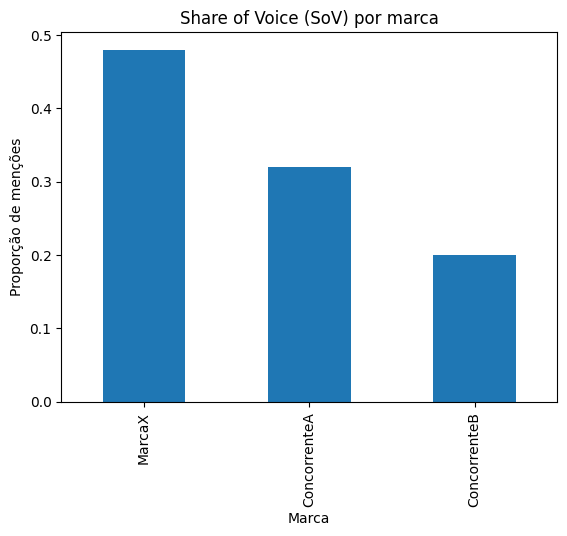

In [ ]:
# ============================
# 6.1 SHARE OF VOICE (SOV)
# ============================

# Conta menções por marca.
contagem_marca = df["marca"].value_counts()

# Total de menções.
total = len(df)

# Calcula SoV.
sov = (contagem_marca / total).sort_values(ascending=False)

print("Share of Voice (SoV):")
display((sov * 100).round(1).astype(str) + "%")

# Gráfico de barras.
sov.plot(kind="bar")
plt.title("Share of Voice (SoV) por marca")
plt.xlabel("Marca")
plt.ylabel("Proporção de menções")
plt.show()


sentimento_pred,Negativo,Neutro,Positivo
marca,,,
ConcorrenteA,43.8,25.0,31.2
ConcorrenteB,50.0,10.0,40.0
MarcaX,54.2,25.0,20.8


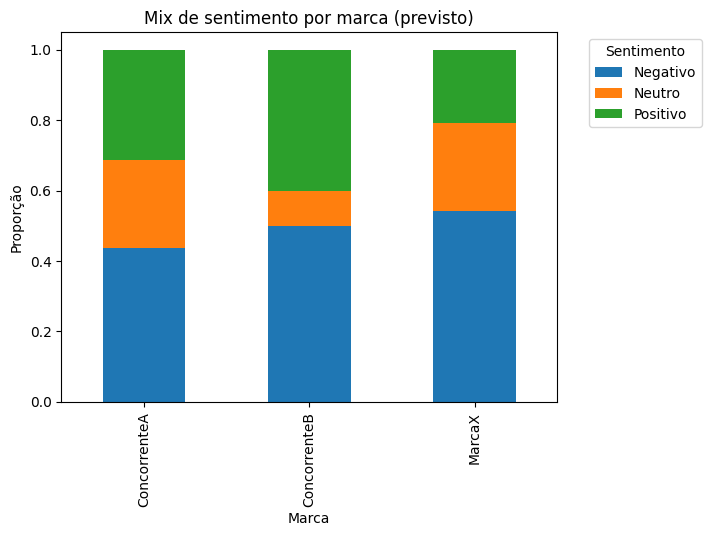

In [ ]:
# ================================
# 6.2 MIX DE SENTIMENTO POR MARCA
# ================================

# Tabela: marca x sentimento previsto.
mix = pd.crosstab(df["marca"], df["sentimento_pred"], normalize="index")

# Exibe em porcentagem.
display((mix * 100).round(1))

# Gráfico empilhado.
mix.plot(kind="bar", stacked=True)
plt.title("Mix de sentimento por marca (previsto)")
plt.xlabel("Marca")
plt.ylabel("Proporção")
plt.legend(title="Sentimento", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()


,count
canal,
Instagram,13
ReclameAqui,12
Twitter/X,11
Facebook,5
YouTube,5
TikTok,4


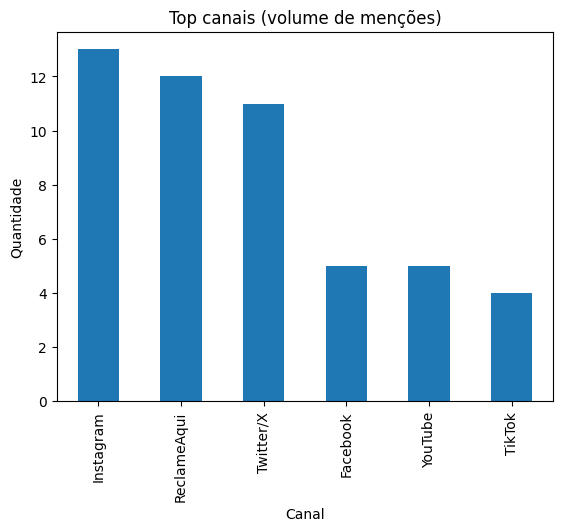

,count
tema,
qualidade,11
suporte,9
entrega,8
atendimento,7
promoção,6
app,4
preço,3
pagamento,2


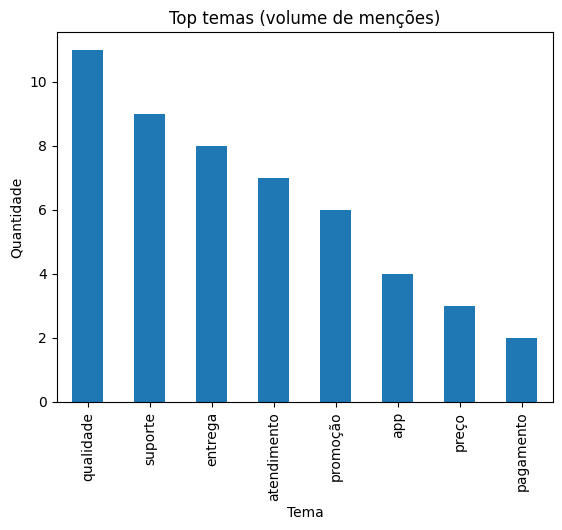

In [ ]:
# ============================
# 6.3 CANAIS E TEMAS
# ============================

# Top canais no total.
top_canais = df["canal"].value_counts().head(10)
display(top_canais)

top_canais.plot(kind="bar")
plt.title("Top canais (volume de menções)")
plt.xlabel("Canal")
plt.ylabel("Quantidade")
plt.show()

# Top temas no total.
top_temas = df["tema"].value_counts().head(10)
display(top_temas)

top_temas.plot(kind="bar")
plt.title("Top temas (volume de menções)")
plt.xlabel("Tema")
plt.ylabel("Quantidade")
plt.show()


## 7) Tendências no tempo e alerta de crise:

### Sinais comuns de crise.
- **pico de volume** (muitas menções em pouco tempo).
- **aumento da proporção de negativos**.
- concentração em canais críticos (ex.: sites de reclamação).
- repetição de temas específicos (ex.: “entrega atrasada”, “reembolso”).

Aqui vamos montar um alerta simples:
- agregação diária por marca.
- cálculo de média móvel (7 dias).
- flag quando o volume do dia > (média móvel + 2 * desvio padrão).


In [ ]:
# ============================
# 7) ALERTA DE CRISE (VOLUME)
# ============================

# Filtra a marca principal (MarcaX).
marca_principal = "MarcaX"
df_marca = df[df["marca"] == marca_principal].copy()

# Agrega por dia: volume total e volume negativo.
diario = (
    df_marca
    .groupby("dia")
    .agg(
        volume=("id", "count"),
        negativos=("sentimento_pred", lambda s: (s == "Negativo").sum())
    )
    .reset_index()
)

# Calcula proporção de negativos no dia.
diario["prop_negativos"] = diario["negativos"] / diario["volume"]

# Ordena por data.
diario = diario.sort_values("dia")

# Média móvel de 7 dias para volume (como a base é pequena, pode ter poucos pontos).
diario["mm7_volume"] = diario["volume"].rolling(window=7, min_periods=2).mean()
diario["std7_volume"] = diario["volume"].rolling(window=7, min_periods=2).std()

# Define limiar: média móvel + 2 desvios (heurística).
diario["limiar_alerta"] = diario["mm7_volume"] + 2 * diario["std7_volume"].fillna(0)

# Flag de alerta.
diario["alerta_volume"] = diario["volume"] > diario["limiar_alerta"]

diario


,dia,volume,negativos,prop_negativos,mm7_volume,std7_volume,limiar_alerta,alerta_volume
0,2026-01-10,1,1,1.0,NaN,NaN,NaN,False
1,2026-01-11,1,0,0.0,1.000000,0.000000,1.000000,False
2,2026-01-13,1,0,0.0,1.000000,0.000000,1.000000,False
3,2026-01-14,1,1,1.0,1.000000,0.000000,1.000000,False
4,2026-01-15,2,2,1.0,1.200000,0.447214,2.094427,False
5,2026-01-17,2,1,0.5,1.333333,0.516398,2.366129,False
6,2026-01-19,2,0,0.0,1.428571,0.534522,2.497616,False
7,2026-01-20,1,1,1.0,1.428571,0.534522,2.497616,False
8,2026-01-21,2,1,0.5,1.571429,0.534522,2.640474,False
9,2026-01-22,2,0,0.0,1.714286,0.487950,2.690186,False


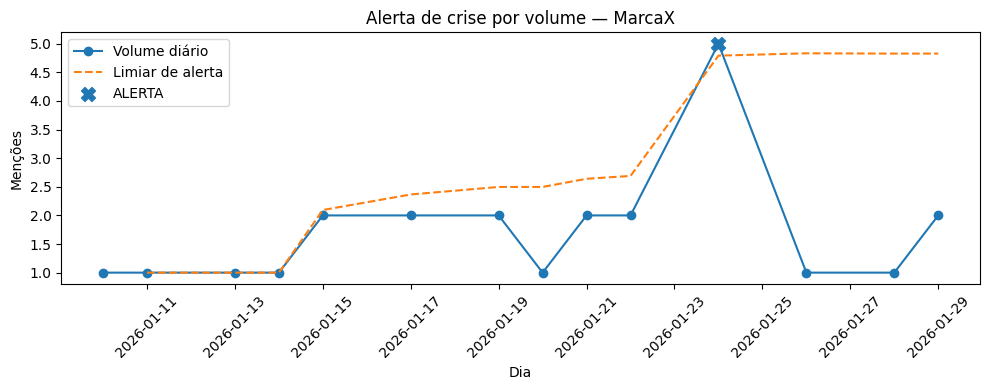

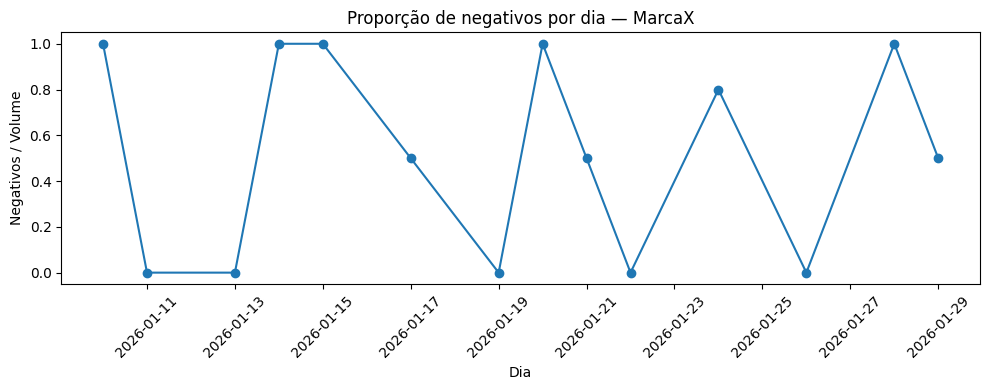

In [ ]:
# Gráfico: volume diário x limiar.
plt.figure(figsize=(10, 4))
plt.plot(diario["dia"], diario["volume"], marker="o", label="Volume diário")
plt.plot(diario["dia"], diario["limiar_alerta"], linestyle="--", label="Limiar de alerta")

# Destaca pontos com alerta.
alertas = diario[diario["alerta_volume"]]
plt.scatter(alertas["dia"], alertas["volume"], s=100, label="ALERTA", marker="X")

plt.title(f"Alerta de crise por volume — {marca_principal}")
plt.xlabel("Dia")
plt.ylabel("Menções")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfico: proporção de negativos.
plt.figure(figsize=(10, 4))
plt.plot(diario["dia"], diario["prop_negativos"], marker="o")
plt.title(f"Proporção de negativos por dia — {marca_principal}")
plt.xlabel("Dia")
plt.ylabel("Negativos / Volume")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 8) Como transformar isso em ação:

**1) Capturar oportunidades**:
- Se o tema “promoção/cupom/cashback” cresce, dá para criar campanhas rápidas e converter intenção.
- Se o canal “TikTok” está puxando volume, prioriza creator strategy naquele canal.

**2) Antecipar crises**:
- Se “ReclameAqui” cresce com “reembolso/defeito”, aciona atendimento e operações.
- Se a proporção de negativos sobe por 2–3 dias, cria war room e plano de resposta.

**3) Governança do monitoramento**:
- Definir taxonomia (temas).
- Definir SLA de resposta por canal.
- Rotina diária: triagem → classificação → dashboard → ações.


## 9) Conclusão:
Neste projeton foi apresentado como:

- Estruturar um pipeline de Social Listening, desde a coleta/ingestão de menções até o tratamento, análise e visualização dos dados

- Monitorar a percepção da marca por meio de métricas de volume, sentimento, canais e temas, considerando janelas temporais

- Identificar tendências e sinais de alerta para antecipação de crises, como picos de menções e aumento de sentimentos negativos

- Transformar dados não estruturados em insights acionáveis, apoiando a tomada de decisão estratégica nas áreas de marketing, atendimento e produto

Esse fluxo reforça como o uso estruturado de dados de Social Listening permite sair da reação tardia e evoluir para uma gestão proativa da reputação e das oportunidades de mercado.


## Próximo nível para aumentar senioridade e conhecimento:

- Conectar uma API real (ex.: X, YouTube, ReclameAqui via scraping legal e consentido).
- Usar um modelo de linguagem em PT-BR (BERTimbau / transformers) para sentimento e tópicos.
- Detecção de tópicos (BERTopic) e entidades (NER).
- Dashboard em **Looker Studio** / **Power BI**.
- Alertas automáticos (e-mail/Slack) quando disparar crise.

